In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import os
sys.path.insert(0, '../')

# import embedding methods
from embedding.bernoulli import Bernoulli
from embedding.kl import KL
from embedding.matrix_factorization import MatrixFactorization

# import evaluation methods
from evaluation import evaluate_link_prediction
from evaluation import evaluate_node_classification
from evaluation import evaluate_node_clustering
# 
# import utils
from utils import graph_util
from utils import plot_util
from utils import model_util

# visualization
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Experiment 1

In [61]:
# Experiment 1

exp = {
    "max_epochs": 750,
    "learning_rate": 1e-2, #Adam
    "weight_decay": 1e-7,
    
    "link_prediction":True,
    "link_pred_num_rounds": 10,
    "link_pred_train_ratio": 0.8,
    "link_pred_eval_every_n_steps": 20,
    "link_pred_edge_emb_method": "average",
    
    "node_classification": True,
    "node_class_num_rounds": 10,
    "node_class_train_ratio": 0.8,
    "node_class_eval_every_n_steps": 50,
    
    "node_clustering": True,
    "node_clustering_num_rounds": 10,
    "node_clustering_eval_epochs": 2,
}


datasets = ["cora", "citeseer", "polblogs","hvr"] 

#TO DO:
#Laplacian (nobrainer) : Till done
#NetMF : Tillcd
#PPR : Till done(?)
#Sum_Power_Tran : Jan
#Sim_Rank : Jan
#Big Task: what to do with W / U Epsilon : Jan
#possible: Forest Fire / Stochastic Optimization


#Bernoulli
model_01 = Bernoulli(embedding_dimension=64, decoder='sigmoid') #works!
model_02 = Bernoulli(embedding_dimension=64, decoder='sigmoid', W_enabled=True)
model_03 = Bernoulli(embedding_dimension=64, decoder='gaussian') #works!
model_04 = Bernoulli(embedding_dimension=64, decoder='exponential') #works!
#model_05 = Bernoulli, exponential with W


#KL
#KL(similarity_measure{needs to be row stochastic}|softmax(ZZ^T))
model_06 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='ppr')
model_07 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sum_power_tran')
model_08 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sim_rank')
model_09 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='transition')
model_10 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='ppr', W_enabled=True)
model_11 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sum_power_tran', W_enabled=True)
model_12 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sim_rank', W_enabled=True)
model_13 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='transition', W_enabled=True)


#Matrix Factorization
model_14 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency', embedding_option=1) #works!
model_15 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian', embedding_option=1) 
model_16 = MatrixFactorization(embedding_dimension=64, similarity_measure='transition', embedding_option=1)
model_17 = MatrixFactorization(embedding_dimension=64, similarity_measure='sym_normalized_laplacian', embedding_option=1) #works!
model_18 = MatrixFactorization(embedding_dimension=64, similarity_measure='NetMF', embedding_option=1)
model_19 = MatrixFactorization(embedding_dimension=64, similarity_measure='ppr', embedding_option=1)
model_20 = MatrixFactorization(embedding_dimension=64, similarity_measure='sum_power_tran', embedding_option=1)
model_21 = MatrixFactorization(embedding_dimension=64, similarity_measure='sim_rank', embedding_option=1)

model_22 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency', embedding_option=2) #works!
model_23 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian', embedding_option=2) 
model_24 = MatrixFactorization(embedding_dimension=64, similarity_measure='transition', embedding_option=2)
model_25 = MatrixFactorization(embedding_dimension=64, similarity_measure='sym_normalized_laplacian', embedding_option=2) #works!
model_26 = MatrixFactorization(embedding_dimension=64, similarity_measure='NetMF', embedding_option=2)
model_27 = MatrixFactorization(embedding_dimension=64, similarity_measure='ppr', embedding_option=2)
model_28 = MatrixFactorization(embedding_dimension=64, similarity_measure='sum_power_tran', embedding_option=2)
model_29 = MatrixFactorization(embedding_dimension=64, similarity_measure='sim_rank', embedding_option=2)

# model_14, model_15, model_16, 
embedding_methods = [
            model_01, model_03,
            model_06,model_07, model_09,
            model_14,model_15,model_16,model_17,
            model_18,model_19,model_20 ]



dset_NMI=[]
dset_AUC=[]
dset_ACC=[]
# setup folders to store experiment setup summary and results
result_folder = plot_util.setup_folders_and_summary_files(exp, datasets, embedding_methods)
print(f'The results of the current experiment are stored at experiments/{result_folder}')

for dataset in datasets:
    
    # load dataset
    total_NMI=[]
    total_AUC=[]
    total_ACC=[]
    A, y = graph_util.load_dataset(dataset)
    
    for model in embedding_methods:
        
        print(model.get_method_summary())
        start = time.time()
        
        directory= 'results_plot/'+dataset+'/'+str(model._method_name)
        if(not os.path.isdir(directory)):
            os.mkdir(directory)
        
        # do link prediction
        if(exp["link_prediction"]):
            link_prediction_folder = result_folder + "/link_prediction"
            AUC= evaluate_link_prediction.expLP(A,dataset,model,exp["link_pred_num_rounds"],
                                           link_prediction_folder, train_ratio=exp["link_pred_train_ratio"], 
                                           edge_emb_method=exp["link_pred_edge_emb_method"],train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["link_pred_eval_every_n_steps"], undirected=True)
            total_AUC.append(AUC)
            
            if(not os.path.isdir(directory+'/link_prediction')):
                os.mkdir(directory+'/link_prediction')
                
            with open(directory+'/link_prediction/'+str(model._similarity_measure)+'_AUC_results.txt','w') as f:
                for listitem in AUC:
                    f.write('%s\n' % listitem) 
                    
        # do node classification
        if(exp["node_classification"]):
            node_classification_folder = result_folder + "/node_classification"
            ACC = evaluate_node_classification.expNC(A,y,dataset,model,exp["node_class_num_rounds"],
                                               node_classification_folder, train_ratio=exp["node_class_train_ratio"],
                                               train_epochs=exp["max_epochs"],eval_epochs=exp["node_class_eval_every_n_steps"],undirected=True)
            total_ACC.append(ACC)
            
            if(not os.path.isdir(directory+'/node_classification')):
                os.mkdir(directory+'/node_classification')
                
            with open(directory+'/node_classification/'+str(model._similarity_measure)+'_ACC_results.txt','w') as f:
                for listitem in ACC:
                    f.write('%s\n' % listitem) 
         
        # do node clustering
        if(exp["node_clustering"]):
            node_clustering_folder = result_folder + "/node_clustering"
            NMI = evaluate_node_clustering.exp_Node_Clustering(A,y,dataset,model,exp["node_clustering_num_rounds"],
                                           node_clustering_folder , train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["node_clustering_eval_epochs"],undirected=True)
            total_NMI.append(NMI)
            
            if(not os.path.isdir(directory+'/node_clustering')):
                os.mkdir(directory+'/node_clustering')
                
            with open(directory+'/node_clustering/'+str(model._similarity_measure)+'_NMI_results.txt','w') as f:
                for listitem in NMI:
                    f.write('%s\n' % listitem)    
                    
        end = time.time()
        print(f'Model evaluation took: {end-start} seconds')
        
    dset_NMI.append(total_NMI)
    dset_AUC.append(total_AUC)
    dset_ACC.append(total_ACC)

The results of the current experiment are stored at experiments/results/2020_01_18_20_31
Bernoulli_sigmoid_adjacency_64_False

Link prediction evaluation has started...


Round: 1

Epoch    0, loss = 0.98155

Round: 2

Epoch    0, loss = 0.97218

=> mean auc score: 0.5623738081066256

Node classification evaluation has started...

Epoch    0, loss = 1.03943
mean accuracy score: 0.19215291750503016

Node clustering evaluation has started...

Epoch    0, loss = 1.01637
0.0056991133494681614
0.00401167427484205
Model evaluation took: 7.689444303512573 seconds
KL_64_softmax_ppr_False

Link prediction evaluation has started...


Round: 1

Epoch    0, loss = 0.00619

Round: 2

Epoch    0, loss = 0.00620

=> mean auc score: 0.5615451723212306

Node classification evaluation has started...

Epoch    0, loss = 0.00636
mean accuracy score: 0.21327967806841047

Node clustering evaluation has started...

Epoch    0, loss = 0.00636
0.002419260108254119
0.003327512777298076
Model evaluation took: 10

KeyboardInterrupt: 

In [20]:

    
headers= [  'sig','gau',
            'ppr','spt','sr',
            'adj','lap','ftr','nl','nf', 'fppr', 'fspt'
         ]

headers= [  'sig']


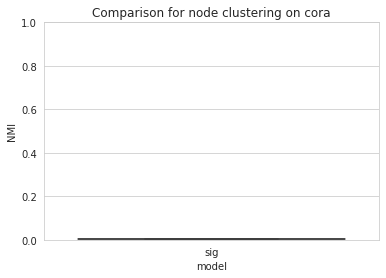

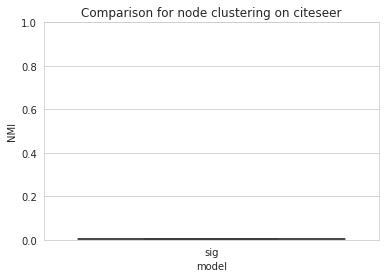

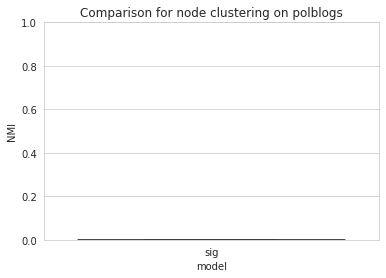

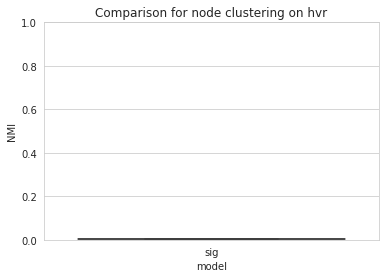

In [21]:

for ds,NMI in zip(datasets,dset_NMI):
    plt.figure()
    sns_plot = sns.boxplot(x=headers, y=NMI);
    plt.title("Comparison for node clustering on "+ds)
    plt.xlabel("model")
    plt.ylabel("NMI")
    plt.ylim([0.,1.])
    sns_plot.figure.savefig('plots/'+ds+'/NMI_'+ds+'.png')

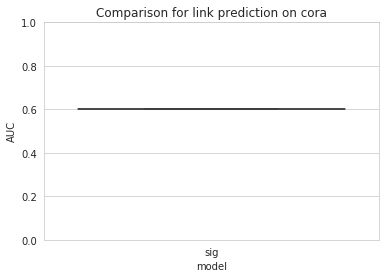

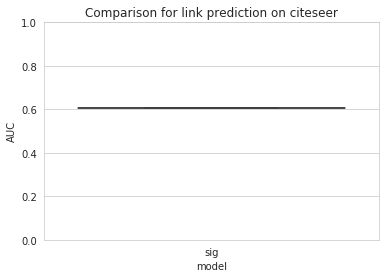

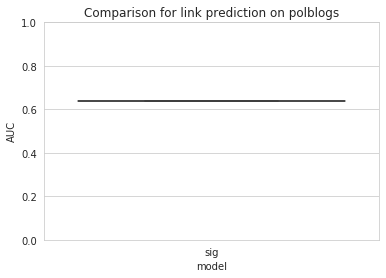

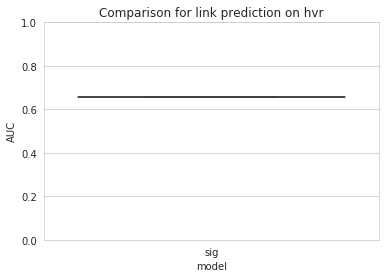

In [24]:
for ds,AUC in zip(datasets,dset_AUC):
    plt.figure()
    sns_plot = sns.boxplot(x=headers, y=AUC);
    plt.title("Comparison for link prediction on "+ds)
    plt.xlabel("model")
    plt.ylabel("AUC")
    plt.ylim([0.,1.])
    sns_plot.figure.savefig('plots/'+ds+'/AUC_'+ds+'.png')

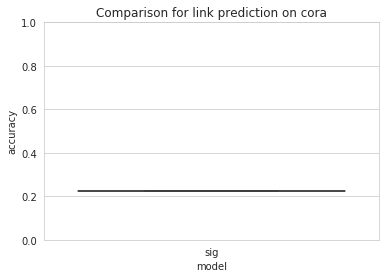

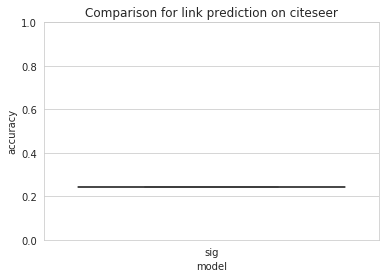

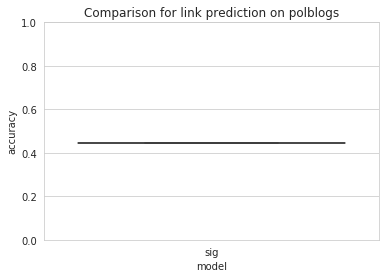

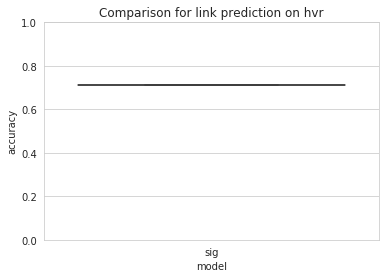

In [23]:
for ds,ACC in zip(datasets,dset_ACC):
    plt.figure()
    sns_plot = sns.boxplot(x=headers, y=ACC);
    plt.title("Comparison for link prediction on "+ds)
    plt.xlabel("model")
    plt.ylabel("accuracy")
    plt.ylim([0.,1.])
    sns_plot.figure.savefig('plots/'+ds+'/ACC_'+ds+'.png')